# Logistic Regression: Predicting heart transplant outcomes and heart failure risks.

## Introduction

In the healthcare industry, predicting patient outcomes can often be a matter of life and death. One specific area where accurate predictions can make a significant impact is in heart transplants. Knowing the likelihood of survival post-transplant can inform medical decisions and prepare families for various outcomes.

The aim of this project is to predict the survival of patients after a heart transplant. I will use Logistic Regression, a powerful algorithm commonly used for binary classification problems. By the end of this project, I will have a model capable of predicting patient survival based on their age at the time of the transplant.

## Objectives

1. **Data Preparation**: Load and preprocess the heart transplant data.
2. **Exploratory Data Analysis (EDA)**: Investigate the data to identify patterns and characteristics.
3. **Mathematical Concepts**: Understand the math behind Logistic Regression.
4. **Model Implementation**: Build and evaluate the Logistic Regression model.
5. **Analysis and Conclusion**: Discuss the model's performance and potential applications.

## Logistic Regression: An Introduction

Logistic regression, despite its name, is a model primarily used for binary classification. In this notebook, we'll explore this fascinating model, its mathematical foundations, and its application in predicting heart transplant survival.

### Binary Classification

In a binary classification problem, each data point belongs to one of $c=2$ possible classes. Conventionally, these classes are labeled "0" and "1." However, the framework can be extended to multiclass problems as well.

### Gradient Ascent/Descent

It's beneficial to review the concept of gradient ascent/descent for optimizing scalar functions of a vector variable. This concept will be crucial when we delve into the mathematical optimization of logistic regression.

### Notations and Matrix Representation

To represent our data, we'll use the following notations:

$\hat{x}_i^T \equiv \left( x_{i,0}, x_{i,1}, \ldots, x_{i,d-1}, 1 \right)$

Each observation $\hat{x}_i$ is a $d$-dimensional vector augmented by an initial dummy coordinate whose value is 1. This is quite similar to what we observed in linear regression.

We can stack these vectors as rows in a matrix $X$:

$X \equiv \left( \hat{x}_0^T, \hat{x}_1^T, \ldots, \hat{x}_{m-1}^T \right)$

And the labels can be a binary vector $y^T \equiv \left( y_0, y_1, \ldots, y_{m-1} \right)^T$.

### Numpy Tips

#### Slicing Columns

In Numpy, if we wish to extract a column $i$ from a matrix $A $ and keep it as a column vector, we need to use the slicing notation $A[:, i:i+1] $. Failing to do so can lead to subtle bugs.

#### Broadcasting

Numpy's broadcasting rule attempts to make shapes compatible when the shapes of two objects do not match.

## Imports

Let's start exploring a simple Logistic Regression by loading the required dataset and investigating it.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from scipy.special import expit as logistic
from scipy.linalg import LinAlgError

## Data Preparation

The dataset used in this project is on heart transplant survival. It contains the following columns:

- **Age_at_Transplant**: The age of the patient at the time of the transplant.
- **Survival_Status**: Survival status after the transplant (1 = Dead, 0 = Alive).
- **Survival_Time**: Time (in days) after the transplant.

Let's start by loading the data and taking a look at the first few entries.


In [18]:
with open("heart_transplant.txt", 'r') as f:
    lines = f.readlines()
parsed_data = [list(map(int, line.strip().split())) for line in lines]

column_names = ['Age_at_Transplant', 'Survival_Status', 'Survival_Time']
heart_data = pd.DataFrame(parsed_data, columns=column_names)

heart_data.head()

,Age_at_Transplant,Survival_Status,Survival_Time
0,41,1,5
1,40,1,16
2,54,1,16
3,29,1,17
4,55,1,28


Now that the data is loaded, the next steps involve data cleaning and exploratory data analysis.
## Exploratory Data Analysis (EDA)

Before diving into model building, it's essential to understand the dataset's characteristics and structure. I'll start by checking for missing values, data types, and some basic statistics.

### Data Info

In [19]:
data_info = heart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Age_at_Transplant  69 non-null     int64
 1   Survival_Status    69 non-null     int64
 2   Survival_Time      69 non-null     int64
dtypes: int64(3)
memory usage: 1.7 KB


All columns have 69 non-null entries and are of integer data type.

### Summary Statistics

In [20]:
data_description = heart_data.describe()
round(data_description,2)

,Age_at_Transplant,Survival_Status,Survival_Time
count,69.00,69.00,69.00
mean,45.48,0.65,415.41
std,8.86,0.48,458.67
min,19.00,0.00,5.00
25%,42.00,0.00,72.00
50%,47.00,1.00,207.00
75%,52.00,1.00,630.00
max,64.00,1.00,1799.00


A quick summary:

- **Age_at_Transplant**: Ranges from 19 to 64 years with an average age of approximately 45.48 years.
- **Survival_Status**: Binary outcome with most cases being 1 (Dead).
- **Survival_Time**: Varies from 5 days to 1799 days with a mean of approximately 415.41 days.

## Data Visualization

Visualizing the dataset can provide valuable insights into its structure and the relationships between variables. Here, I'll visualize the distribution of the features and the target variable.

### Distribution of Age at Transplant
From the plot we can see that the age of transplant patients in the data ranges from 20 to ~60 years and the majority of them are aged around 17-52.

### Distribution of Survival Status
Based on our data, over 65% of the studied patients survived the heart transplant surgery.

### Distribution of Survival Time
Survival time ranges from 0 to ~1750 days. The high count of the '0' survival time is likely related to the cases where the patient did not survive the transplant. WE can also observe that although some patients had survival time under 500 days, there are those who lived a lot more thanks to the surgery.

Text(0, 0.5, 'Frequency')

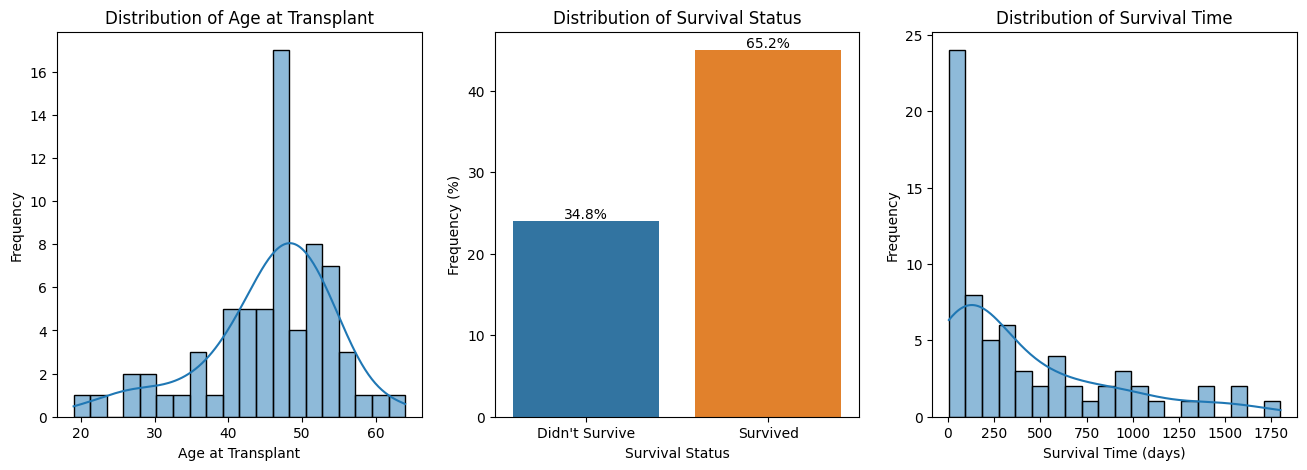

In [21]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
sns.histplot(heart_data['Age_at_Transplant'], kde=True, bins=20)
plt.title('Distribution of Age at Transplant')
plt.xlabel('Age at Transplant')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
ax = sns.countplot(x='Survival_Status', data=heart_data)
plt.title('Distribution of Survival Status')
plt.xlabel('Survival Status')
plt.ylabel('Frequency (%)')
total = len(heart_data['Survival_Status'])
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')
plt.xticks([0, 1], ['Didn\'t Survive', 'Survived'])

plt.subplot(1, 3, 3)
sns.histplot(heart_data['Survival_Time'], kde=True, bins=20)
plt.title('Distribution of Survival Time')
plt.xlabel('Survival Time (days)')
plt.ylabel('Frequency')

## Mathematical Concepts

Logistic Regression is the algorithm of choice for this binary classification problem. It models the relationship between a set of features and a binary outcome variable. The algorithm estimates probabilities using a logistic function, which is an S-shaped curve.

The logistic function is given by:

$P(y=1) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x)}}$

Where:
- $ P(y=1) $ is the probability of the target variable $y$ being 1.
- $ \beta_0 $ is the y-intercept.
- $ \beta_1 $ is the coefficient for the feature $x$.

### Diving Deep: Linear Discriminants and Heaviside Function

#### Linear Discriminants

To make our logistic regression model robust, it's essential to understand the geometry behind it. A linear discriminant is a boundary that separates different classes in a dataset. In our case, the boundary could be represented by $\theta^T \! x = 0$.

$\theta^T \! x = \theta_0 x_0 + \theta_1 x_1 + \theta_2$

$x_1  = -\frac{\theta_2}{\theta_1} - \frac{\theta_0}{\theta_1} x_0$

#### Heaviside Function

To transform these boundaries into actual class labels, we use the Heaviside function $H(y)$. It takes a value $y$ and converts it into 0 or 1 based on its sign.

$
H(y) = \begin{cases} 
1 & \text{if } y > 0 \\
0 & \text{if } y \leq 0 
\end{cases}
$

#### Comparison Plot
Below is the plot comparing the Logistic Function (Soft) with the Heaviside Function (Hard) on synthetic data. The logistic function provides a smooth transition, giving us probabilities, while the Heaviside function offers a more abrupt, binary classification.

### Model Implementation

Let's implement logistic regression on our heart transplant data.

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


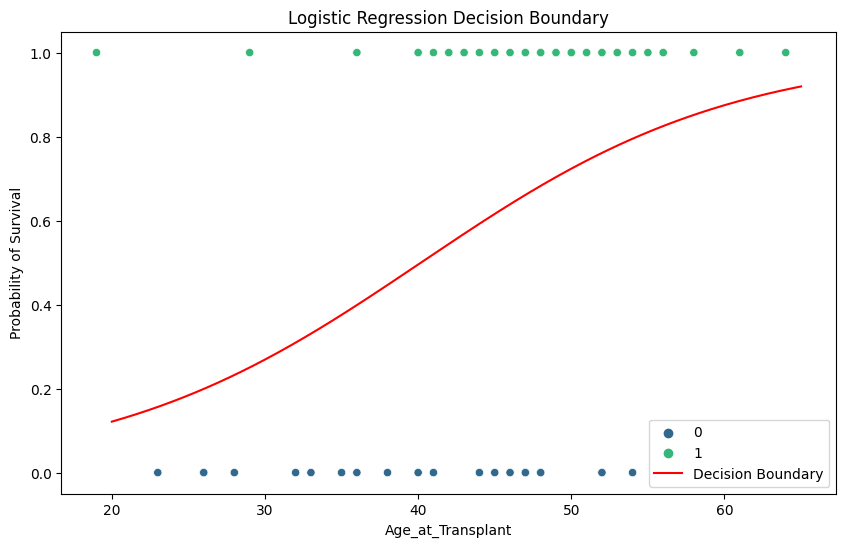

Model Accuracy: 0.79


/opt/conda/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


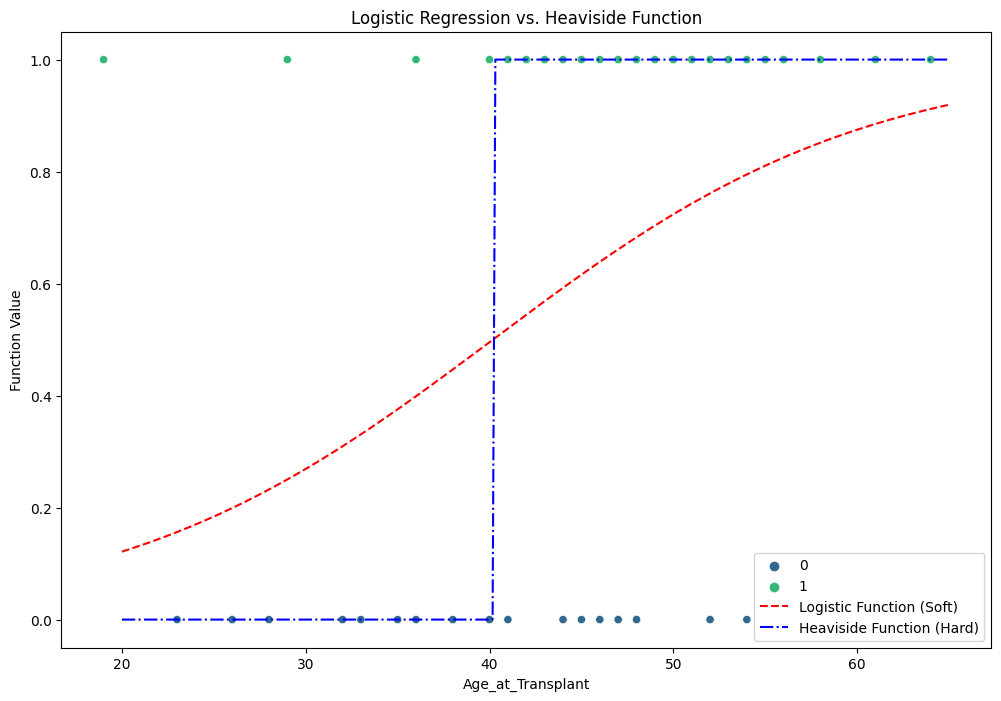

In [22]:
# Split the data into features and target variable
X = heart_data[['Age_at_Transplant']]
y = heart_data['Survival_Status']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Logistic Regression model
model = LogisticRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

# Generate plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age_at_Transplant', y='Survival_Status', data=heart_data, hue='Survival_Status', palette="viridis")
plt.title('Logistic Regression Decision Boundary')

# Generate x-values
x_values = np.linspace(20, 65, 300)
x_values = x_values.reshape(-1, 1)

# Calculate the probabilities using the logistic regression model
y_values = model.predict_proba(x_values)[:, 1]

plt.plot(x_values, y_values, label='Decision Boundary', color='red')
plt.xlabel('Age_at_Transplant')
plt.ylabel('Probability of Survival')
plt.legend()
plt.show()

print(f"Model Accuracy: {accuracy:.2f}")

def logistic(Y):
    return 1 / (1 + np.exp(-Y))

def heaviside(Y):
    return np.heaviside(Y, 0.5)

plt.figure(figsize=(12, 8))
sns.scatterplot(x='Age_at_Transplant', y='Survival_Status', data=heart_data, hue='Survival_Status', palette="viridis")
plt.title('Logistic Regression vs. Heaviside Function')

x_values = np.linspace(20, 65, 300)
x_values_reshaped = x_values.reshape(-1, 1)

# Calculate the probabilities using the logistic regression model
y_prob_values = model.predict_proba(x_values_reshaped)[:, 1]

# Calculate Heaviside values
y_heaviside_values = heaviside(y_prob_values - 0.5)

plt.plot(x_values, y_prob_values, label='Logistic Function (Soft)', color='red', linestyle='--')
plt.plot(x_values, y_heaviside_values, label='Heaviside Function (Hard)', color='blue', linestyle='-.')
plt.xlabel('Age_at_Transplant')
plt.ylabel('Function Value')
plt.legend()
plt.show()


## Analysis and Conclusion

After implementing the Logistic Regression model, it's crucial to evaluate its performance to understand its efficacy and limitations.

### Model Performance

The model achieved an accuracy of approximately 78.57% on the test data. This is a decent score for a data set this size, and it's essential to dig deeper into other metrics and predictors (such as pre-op health condition) for a more comprehensive evaluation of survival rates.

### Confusion Matrix
We have two false positive predictions, where the model predicted that the patient would survive, but they did not, and one false negative, where the patient survived but the model predicted otherwise.

### Classification Report
The classification report provides the following metrics:

- **Precision**: 0.50 for class 0 and 0.83 for class 1
- **Recall**: 0.33 for class 0 and 0.91 for class 1
- **F1-Score**: 0.40 for class 0 and 0.87 for class 1

### Model Fit Visualization
The plot shows the actual vs. the predicted values for the test set, providing a visual representation of how well the model fits the data.

### Thoughts

The model performs reasonably well but could be improved with feature engineering or by trying out different algorithms. Despite its limitations, it serves as a foundational step in predicting heart transplant survival and has potential applications in healthcare settings.

[[ 1  2]
 [ 1 10]]
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.83      0.91      0.87        11

    accuracy                           0.79        14
   macro avg       0.67      0.62      0.63        14
weighted avg       0.76      0.79      0.77        14



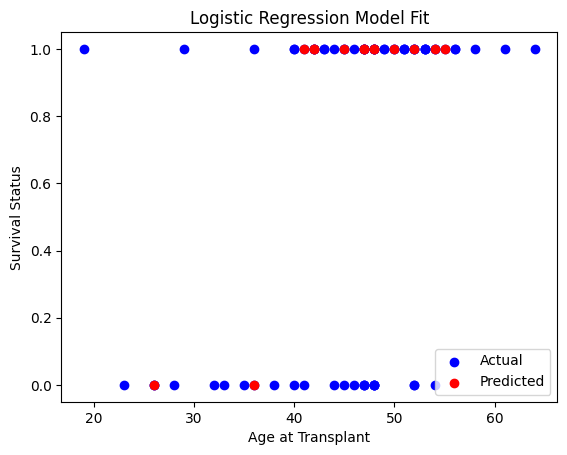

In [23]:
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

class_report = classification_report(y_test, y_pred)
print(class_report)

plt.scatter(X, y, color='blue', label='Actual')
plt.scatter(X_test, y_pred, color='red', label='Predicted')
plt.xlabel('Age at Transplant')
plt.ylabel('Survival Status')
plt.title('Logistic Regression Model Fit')
plt.legend()

# Predicting Heart Failure
## Multidimensional Analysis and Probability Contours

After analyzing data with a single predictor in the heart transplant dataset, it became clear that a more complex model was needed. This led to the decision to switch to a heart failure prediction dataset that has multiple features. The goal is to better understand the intricacies of logistic regression in a multi-dimensional space.

#### Why the New Dataset?
The initial dataset, focused on heart transplants, was insightful but limited in features. The new dataset not only provides a rich set of predictors but is also well-balanced, allowing for a more reliable model.

#### Mathematical Foundation of Multi-Feature Logistic Regression
In multi-feature logistic regression, the sigmoid function is extended to accommodate multiple predictors as follows:

$G(\theta^T x) = \frac{1}{1 + e^{-\theta^T x}}$

Where:

$\theta^T x = \theta_0 + \theta_1 \cdot x_1 + \theta_2 \cdot x_2 + \ldots + \theta_n \cdot x_n $

#### Contour Plot for Decision Boundary
In a multi-dimensional space, the decision boundary is no longer a simple line; it becomes a contour plot. The plot visualizes how the probability of experiencing a death event varies based on different combinations of 'Ejection fraction' and 'Serum creatinine'.

The contour plot gives us a visual representation of how the logistic regression model "thinks." Each contour line represents points in the feature space where the model predicts a specific probability of heart failure. The red regions indicate higher probabilities (higher risk), while the blue regions indicate lower probabilities (lower risk).

$p = \frac{1}{1 + e^{-(\beta_0 + \beta_1 \times \text{Ejection fraction} + \beta_2 \times \text{Serum creatinine})}}$

In the contour plot, each color signifies a range of probabilities. The blue regions indicate low-risk zones, while the red regions are high-risk zones. This provides a comprehensive understanding of how the logistic model assesses risk based on multiple factors.



In [24]:
heart_failure_data = pd.read_csv('heart_failure_clinical_records_dataset.csv')

heart_failure_data.info()
heart_failure_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [25]:
X_multi = heart_failure_data.drop(['DEATH_EVENT'], axis=1)
y_multi = heart_failure_data['DEATH_EVENT']

X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi, y_multi, test_size=0.2, random_state=42)

multi_model = LogisticRegression(max_iter=1000)

multi_model.fit(X_train_multi, y_train_multi)

y_pred_multi = multi_model.predict(X_test_multi)

multi_accuracy = accuracy_score(y_test_multi, y_pred_multi)
print(f'Accuracy: {multi_accuracy}')


Accuracy: 0.8


## Maximum Likelihood Estimation in Logistic Regression

After delving into multi-dimensional logistic regression, let's take a detour to explore how logistic regression models are actually fitted to data. This is where Maximum Likelihood Estimation (MLE) comes into play.

### The Concept of Likelihood

In logistic regression, the aim is to find the model parameters that maximize the likelihood of observing the given labels in the dataset. Mathematically, this is expressed as:

$\text{Maximize } \mathcal{L}(\theta; y, X) = \sum_{i=0}^{m-1} y_i \ln g_i + (1-y_i) \ln (1-g_i)$

Here, $g_i = \frac{1}{1 + e^{-(\theta^T \hat{x}_i)}}$ is the predicted probability of observing label $y_i$ given the features $\hat{x}_i$.

### Why Log-Likelihood?

For computational stability and ease of calculation, we often use the natural logarithm of the likelihood, termed as log-likelihood. This transformation turns products into sums and exponents into coefficients, making it easier to work with.

### Objective in Our Case

We'll calculate the log-likelihood for our heart failure dataset using the selected features and attempt to interpret the outcome:


In [26]:
# Model using 2 variables
X_mle = heart_failure_data[['ejection_fraction', 'serum_creatinine']].values
y_mle = heart_failure_data['DEATH_EVENT'].values
X_mle = np.hstack([np.ones((X_mle.shape[0], 1)), X_mle])
X_train, X_test, y_train, y_test = train_test_split(X_mle, y_mle, test_size=0.2, random_state=42)


def log_likelihood(theta, X, y):
    epsilon = 1e-5
    g = 1 / (1 + np.exp(-X.dot(theta)))
    return np.sum(y * np.log(g + epsilon) + (1 - y) * np.log(1 - g + epsilon))

mle_model = LogisticRegression(fit_intercept=False)
mle_model.fit(X_train, y_train)
theta_mle = mle_model.coef_.reshape(-1)
theta_mle = mle_model.coef_.reshape(-1)

log_likelihood_value = log_likelihood(theta_mle, X_test, y_test)
log_likelihood_value


-38.96618937534863

For our heart failure prediction model using just two predictors **'ejection_fraction', 'serum_creatinine'**, we calculated a **log-likelihood of approximately −38.97**. This value serves as a measure of how well our model's parameters fit the data.

We can do the same for the model with all the parameters and compare the log-likelihoods. The higher the value is, the better the model fits the data.

In [27]:
# Using all features
features_all = ['age', 'anaemia', 'high_blood_pressure', 'creatinine_phosphokinase', 'diabetes', 
                'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time']
X_mle_all_features = heart_failure_data[features_all].values
y_mle_all_features = heart_failure_data['DEATH_EVENT'].values
X_mle_all_features = np.hstack([np.ones((X_mle_all_features.shape[0], 1)), X_mle_all_features])
X_train_all_features, X_test_all_features, y_train_all_features, y_test_all_features = train_test_split(X_mle_all_features, y_mle_all_features, test_size=0.2, random_state=42)

mle_model_all_features = LogisticRegression(fit_intercept=False, max_iter=1000)
mle_model_all_features.fit(X_train_all_features, y_train_all_features)
theta_mle_all_features = mle_model_all_features.coef_.reshape(-1)

log_likelihood_value_all_features = log_likelihood(theta_mle_all_features, X_test_all_features, y_test_all_features)
log_likelihood_value_all_features


-31.353063542281276

We see that with all the predictors in the model, log likelihood has grown to -31.35. So, in our case, the all-features model with a log-likelihood of -38.97 is a **better fit** than the two-feature model with a log-likelihood of -31.35.

## Computing the MLE Solution via Gradient Ascent

### Theory Behind Gradient Ascent for MLE

In logistic regression, the idea is to find the best parameters that maximize the log-likelihood function, $\mathcal{L}(\theta; y, X)$. However, unlike linear regression where we can find an analytic solution, here we have to resort to numerical optimization techniques like gradient ascent. 

In simple terms, gradient ascent works by:

1. Starting with an initial guess for $\theta$.
2. Iteratively updating $\theta$ in the direction of the gradient to maximize the log-likelihood.
3. Stopping the updates when $\theta$ doesn't change much or after a certain number of steps.

For a function $f(x)$, the update rule in a single dimension is:

$
x_{\text{new}} = x_{\text{old}} + \alpha \cdot \frac{df(x)}{dx}
$

In multiple dimensions, where $x$ and $\theta$ are vectors, the update rule becomes:

$\theta_{\text{new}} = \theta_{\text{old}} + \alpha \cdot \nabla_\theta \left\{\mathcal{L}(\theta; y, X)\right\}$

Here, $\alpha$ is the learning rate, and $\nabla_\theta$ is the gradient of the log-likelihood function with respect to $\theta$.

For logistic regression, the gradient of the log-likelihood function $\mathcal{L}(\theta; y, X)$ is given by:

$\nabla_\theta \left\{\mathcal{L}(\theta; y, X)\right\} = X^T \left[ y - G(X \cdot \theta)\right]$

where $G$ is the logistic function.

First, we will implement the **gradient of the log-likelihood function**.

Next,  we will delve into the Maximum Likelihood Estimation (MLE) using gradient ascent. Here's our approach:

- We initialize the coefficients, $θ$, randomly or set them to zero.
- Calculate the gradient of the log-likelihood function.
- Update $θ$ using the gradient.
- Repeat until the parameters don't change much or we reach a max number of iterations.

We will use the model with two predictors only for better demonstration of gradient ascent trajectory.

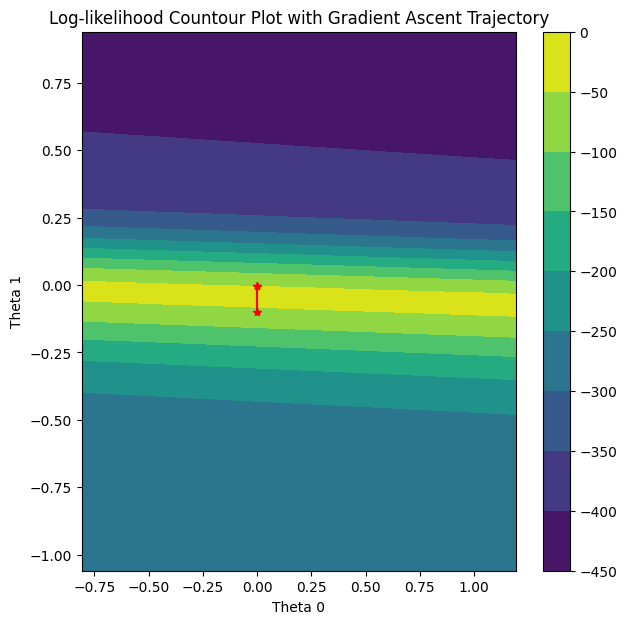

In [28]:
# Correcting the code to convert X_train and y_train to numpy arrays
def gradient_ascent_path(X, y, alpha=0.01, max_iter=100):
    """
    Run gradient ascent to maximize the log-likelihood for logistic regression.
    
    Parameters:
    X (array): The feature matrix.
    y (array): The labels vector.
    alpha (float): The learning rate.
    max_iter (int): The number of iterations to run the algorithm.
    
    Returns:
    array: The final theta values.
    array: The theta values at each iteration.
    """
    theta = np.zeros((X.shape[1], 1))
    all_thetas = np.zeros((X.shape[1], max_iter+1))
    all_thetas[:, 0:1] = theta
    for t in range(max_iter):
        G = 1 / (1 + np.exp(-X.dot(theta)))
        gradient = X.T.dot(y - G)
        gradient /= np.linalg.norm(gradient, ord=2)
        theta += alpha * gradient.reshape(-1, 1)
        all_thetas[:, t+1:t+2] = theta
    
    return theta, all_thetas

X_train_np = np.array(X_train)
y_train_reshaped = np.array(y_train).reshape(-1, 1)
final_theta, all_thetas = gradient_ascent_path(X_train_np, y_train_reshaped, alpha=0.1, max_iter=100)
final_theta, all_thetas[:,:5]

theta_0_vals = np.linspace(theta_mle[0] - 1, theta_mle[0] + 1, 100)
theta_1_vals = np.linspace(theta_mle[1] - 1, theta_mle[1] + 1, 100)
theta_0_grid, theta_1_grid = np.meshgrid(theta_0_vals, theta_1_vals)

ll_grid = np.zeros((100, 100))

for i in range(100):
    for j in range(100):
        theta_tmp = np.array([theta_0_grid[i, j], theta_1_grid[i, j], theta_mle[2]]) 
        ll_grid[i, j] = log_likelihood(theta_tmp, X_test, y_test)

plt.figure(figsize=(7, 7))
cp = plt.contourf(theta_0_grid, theta_1_grid, ll_grid, cmap='viridis')
plt.colorbar(cp)
plt.title('Log-likelihood Countour Plot with Gradient Ascent Trajectory')
plt.xlabel('Theta 0')
plt.ylabel('Theta 1')

plt.plot(all_thetas[:, 0], all_thetas[:, 1], 'r*-') 

plt.show()


On this plot we can see how gradient ascent progresses, and that it takes two steps for the algorithm to converge in this case.

## Numerical optimization via Newton's method
It can be hard to choose $\alpha$ in gradient descent - it is not easy to decide how to choose the step size or direction in a more principled way. One idea is Newton's method, which is what we'll explore below.

#### The Basic Idea in 1-D

Suppose we start at a point $x$ and decide to take a step of size $s$. WE'll then be at $f(x + s)$. In gradient ascent, we make this choice by following the gradient. But Newton's method picks $s$ differently: it aims to maximize $f(x + s)$ using an approximation, $q(s) \approx f(x+s)$.

#### How Do We Approximate?

The approximation, $q(s)$, is a quadratic function. This is better than a linear approximation for two main reasons:

1. It has an extreme point, hopefully, a maximum.
2. It's a higher-order approximation, so it's more accurate.

Mathematically, this approximation is expressed as:
$f(x + s) \approx f(x) + s \frac{df}{dx} + \frac{1}{2} s^2 \frac{d^2 f}{dx^2} = q(s)$

#### Finding the Optimal Step, $s$

To find the optimal step size, we take the derivative of $q(s)$ and solve for $s$ such that $q'(s) = 0$.
$s_* = -\frac{df}{dx} \left(\frac{d^2 f}{dx^2}\right)^{-1}$

#### Extending to Higher Dimensions

In higher dimensions, we'll need the gradient and the Hessian of $f(x)$. The Hessian is basically a matrix of all possible second-order partial derivatives. With the Hessian in hand, Newton's method in multidimensional space looks like this:
$f(x + s) \approx f(x) + {s^T \nabla_x f} + {\frac{1}{2} s^T H_x(f) s} = q(s)$

#### Summary of Newton's Method

To sum up, Newton's method has the following steps:
1. Start with an initial guess $x(0)$.
2. Compute the search direction $s(t)$ by solving $H_{x(t)}(f) \cdot s(t) = - \nabla_x f(x(t))$.
3. Update the guess: $x(t+1) = x(t) + s(t)$.

Next, we'll implement it to perform Maximum Likelihood Estimation (MLE) for logistic regression.


In [29]:

def logistic(x):
    return 1 / (1 + np.exp(-x))

def grad_log_likelihood(theta, y, X):
    return X.T.dot(y - logistic(X.dot(theta)))

def hess_log_likelihood(theta, X):
    G = logistic(X.dot(theta)) * logistic(-X.dot(theta))
    return -(X * G).T.dot(X)

def newton_method(X, y, max_iter=10):
    m, n = X.shape
    theta = np.zeros((n, 1))
    thetas = np.zeros((n, max_iter + 1))
    thetas[:, 0:1] = theta
    
    for t in range(max_iter):
        grad = grad_log_likelihood(theta, y, X)
        try:
            hess = hess_log_likelihood(theta, X)
            step = np.linalg.solve(hess, -grad)
        except LinAlgError:
            step = np.linalg.pinv(hess).dot(-grad)
        theta += step
        thetas[:, t + 1:t + 2] = theta
    
    return theta, thetas

X_train_np = np.array(X_train)
y_train_reshaped = np.array(y_train).reshape(-1, 1)
final_theta_newt, all_thetas_newt = newton_method(X_train_np, y_train_reshaped, max_iter=10)

final_theta_newt, all_thetas_newt[:, :5]


(array([[ 0.22741941],
        [-0.06153824],
        [ 0.81256193]]),
 array([[ 0.        , -0.08872697,  0.1676912 ,  0.22573575,  0.22741818],
        [ 0.        , -0.04081118, -0.0581918 , -0.06144991, -0.06153818],
        [ 0.        ,  0.60445132,  0.78239229,  0.81183096,  0.81256148]]))

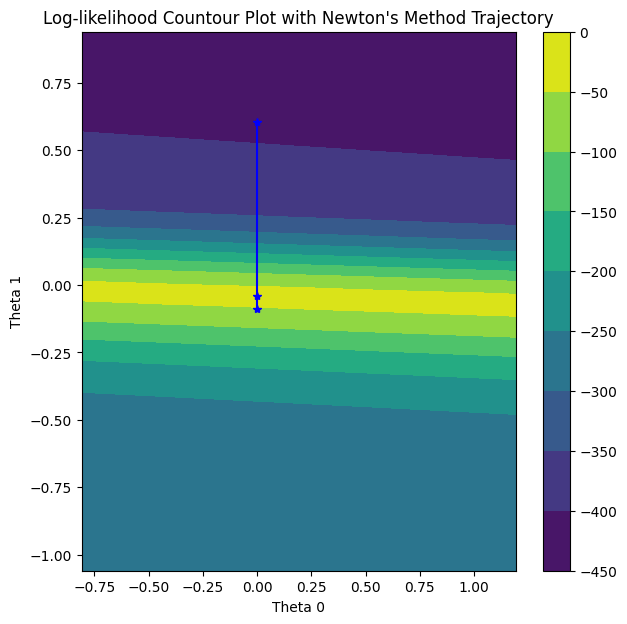

In [30]:
plt.figure(figsize=(7, 7))
cp = plt.contourf(theta_0_grid, theta_1_grid, ll_grid, cmap='viridis')
plt.colorbar(cp)
plt.title('Log-likelihood Countour Plot with Newton\'s Method Trajectory')
plt.xlabel('Theta 0')
plt.ylabel('Theta 1')
plt.plot(all_thetas_newt[:, 0], all_thetas_newt[:, 1], 'b*-')

plt.show()


Here, we can observe that this optimization procedure takes one more step compared to gradient ascent, which might indicate that gradient ascent took larger but potentially riskier jumps, while Newton's method took an extra step to be more precise.

## Final Thoughts

In this notebook, we delved into the intricacies of logistic regression, aiming to predict heart transplant outcomes and heart failure risks. We started with the fundamentals, touching on key mathematical concepts that underpin logistic regression. We then moved on to data exploration, prepping ourselves for the heavy lifting involved in modeling.

We applied both Gradient Ascent and Newton's method for optimization. While Gradient Ascent gave us a decent idea of the MLE solutions, Newton's method offered a more robust and quicker approach, albeit requiring a second-order derivative computation.

Our visualizations, especially the contour plots for decision boundaries, provided an insightful look into how well our model has fit the data. It's fascinating to see how different optimization techniques show different paths to convergence, which gave us a good learning experience in numerical optimization.